### Load Data (MNIST)

Here, we use a suitable object that will hold the data and that will be easier to be referenced from within the MLP.


In [1]:
import numpy as np

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

class Dataset(object):
    
    def __init__(self,x,y,test_size):
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=test_size, random_state=0)
        self.xtrain = xtrain.T
        self.xtest = xtest.T
        self.ytrain = ytrain.T
        self.ytest = ytest.T
                
        self.nx = self.xtrain.shape[0]
        self.mtrain = self.xtrain.shape[1]
        self.mtest = self.xtest.shape[1]

        self.indices = np.arange(self.mtrain)
        np.random.shuffle(self.indices)
        self.counter = 0
        print("Training Data: x=%s | y=%s, Test Data: x=%s | y=%s"%(str(self.xtrain.shape), str(self.ytrain.shape), 
                                                                    str(self.xtest.shape), str(self.ytest.shape)))

                    
    def next_batch(self, batchsize):
        if (self.counter+1)*batchsize >= self.mtrain:
            self.counter = 0
            np.random.shuffle(self.indices)
        it = self.indices[self.counter*batchsize:(self.counter+1)*batchsize]
        self.counter += 1
        xbatch = self.xtrain[:,it].reshape(self.nx, batchsize)
        ybatch = self.ytrain[:,it].reshape(1,batchsize)
        return xbatch, ybatch

    def training_set(self):
        return self.xtrain, self.ytrain

    def test_set(self):
        return self.xtest, self.ytest


In [2]:
mnist = fetch_mldata('MNIST original')
x, y = mnist['data'], np.array(mnist['target'], dtype='int')
y = y.reshape(y.size,1)

ds = Dataset(x,y,test_size=10000)

Training Data: x=(784, 60000) | y=(1, 60000), Test Data: x=(784, 10000) | y=(1, 10000)


### Model Components

In this section, we define the different compartments of the MLP model, including 

* Activation function including suitable methods to compute values and derivatives: here, the simoid activation function will be used. 
* For implementing softmax, a softmax activation function is provided. It just provides the possibility to compute the softmax values, but not the derivatives. The derivatives will be needed for the backpropagation but will be integrated in the code for the softmax layer.  
* Initializer for initializing the weights and bias parameters: here, normally distributed initial values will be provided.
* Cost function used for training - including suitable methods for computing the values and derivatives: here, the cross-entropy cost will be used.
* Layer: The first core component to be implemented/completed by the students.
* MLP: The second core component to be implemented/completed by the students. Allows to configure an arbitrary number of layers into a sequential structure.  


In [3]:
class activation_function(object):
    """
    Empty parent implementation of all activation functions. All child implementations should implement 
    the two methods defined below.
    """
    def compute_value(self, z):
        """
        Computes the value of the activation function element wise for input array z of arbitrary shape. 
        """
        raise NotImplementedError("To be implemented in the child implementation.")
        
    def compute_derivative(self, z):
        """
        Computes the derivative of the activation function element wise for input array z of arbitrary shape. 
        """
        raise NotImplementedError("To be implemented in the child implementation.")


In [4]:
class sigmoid_activation_function(activation_function):
        
    def compute_value(self, z):
        return 1.0 / (1.0 + np.exp(-z))
        
    def compute_derivative(self, z):
        s = self.compute_value(z)
        return s*(1-s)

In [5]:
class softmax_activation_function(activation_function):
    
    def compute_value(self, z):
        expz = np.exp(z)
        norm = np.sum(expz, axis=0)        
        return expz / norm
        
    def compute_derivative(self, z):
        raise NotImplementedError("Computation of the gradient implemented in the Softmax Layer.")

In [6]:
class Norm_Initializer(object):
    
    def initialize_weights(self, size, mu=0.0, sigma=1.0):
        return np.random.normal(size=size, loc=mu, scale=sigma)
    
    def initialize_bias(self, size, mu=0.0, sigma=1.0):
        return np.random.normal(size=size, loc=mu, scale=sigma)

In [7]:
class Cost(object):
    
    def compute_value(self, y, prob):
        """
        Computes the value of the cost function for given labels y and predicted probs. 
        """
        raise NotImplementedError("")
        
    def compute_derivative(self, y, prob):
        """
        Computes the derivative of the cost function for given labels y and predicted probs. 
        """
        raise NotImplementedError("")         

In [8]:
class CrossEntropy(Cost):

    def compute_value(self, y, prob):
        """
        Computes the value of the cost function for given labels y and predicted probs.
        
        Arguments:
        y -- labels, a numpy array of shape (1,m)
        prob -- predicted probabilities for the different classes, a numpy array of shape (ny,m)
        
        Returns:
        cost -- a scalar
        """
        n,m = prob.shape
        assert(np.max(y)<=n)
        py = prob[y,np.arange(m)]
        J = -np.sum(np.log(py))/m    
        return J
    
        
    def compute_derivative(self, y, prob):
        """
        Computes the derivative of the cost function for given labels y and predicted probs. 
        Derivative is computed w.r.t. predicted probs.

        y -- labels (shape (1,m))
        prob -- predicted probabilities for the different classes (shape (ny,m))
        
        Returns:
        Gradient of cost with respect to the predicted probabilities (shape (ny,m))
        """
        n,m = prob.shape
        result = np.zeros((n,m),dtype=float)
        result[y[0,:],np.arange(m)] = 1.0
        result /= prob
        return -result

In [9]:
class Layer(object):
    
    def __init__(self, layerid, nunits, nunits_prev, activ_func, initializer):
        """
        Instantiates a fully connected layer for an MLP, with given number of input and output activations.
        
        Arguments:
        layerid -- integer id for the layer.
        nunits -- number of classes.
        nunits_prev -- number of input activations.
        activ_func -- activation function to be used (with a compute_value and compute_derivative-method).
        initializer -- initializer for the weights and the biases.        
        """
        self.layerid = layerid
        self.nunits = nunits
        self.nunits_prev = nunits_prev
        self.initializer = initializer
        self.activ_func = activ_func
        
        self.weights = None # shape (nunits,nunits_prev)
        self.bias = None # shape (nunits,1)
        self.logits = None # shape(nunits,m) - will be needed for the backprop part ...
        self.activations = None # shape(nunits,m)
        self.grad_logits = None # shape(nunits,m) - will be needed as basis for different gradients
        

    def initialize(self):
        """
        Initializes the weights and biases. It uses Xavier normalisation (to be discussed in "regularisation").
        """
        sigmaw = np.sqrt(2.0/(self.nunits+self.nunits_prev)) # suited for sigmoid activation function
        sigmab = np.sqrt(1.0/self.nunits)
        self.weights = self.initializer.initialize_weights(size=(self.nunits,self.nunits_prev), mu=0.0, sigma=sigmaw)
        self.bias = self.initializer.initialize_bias(size=(self.nunits,1), mu=0.0, sigma=sigmab)
        
    
    def propagate(self, activations_prev):
        """
        Computes the activations of the layer given the activations of the previous layer.
        Caches the computed logits (z-values) and activations since the values will be needed 
        when using backpropagation to compute the gradients w.r.t. weigths and biases.

        Arguments:
        activations_prev -- activations of the previous layer (or input layer). A numpy array of shape 
        (nunits_prev,m).
        
        Returns:
        activations -- activations of this layer, a numpy array of shape (nunits,m)
        """
        np.testing.assert_equal(activations_prev.shape[0],self.nunits_prev)
        ### START YOUR CODE ###

        
        ### END YOUR CODE ###

    
    def backpropagate(self, grad_activations):
        """
        Computes the gradient of the cost w.r.t. to the input activations (activations of the previous 
        layer a^[l-1]) of the given layer. It also computes the gradient w.r.t. the logits (z-values) of 
        the given layer. This will be needed as the basis for computing the gradient of the cost w.r.t. 
        the weights and bias of the given layer. 
        
        The method assumes that the forward propagation (`propagate`) has been invoked for the given mini-batch 
        so that consistent logit-values (self.logits) and activations (self.activations) are available.  
        
        Arguments:
        grad_activations -- gradient of the cost w.r.t. to the output activations of the given layer (a^[l]). 
        A numpy array of shape (nunits_prev,m) 
        
        Returns:
        grad_activations_prev -- gradient of the cost w.r.t. to the input activations of the given layer.
        """
        nsamples =  self.logits.shape[1]
        np.testing.assert_equal(grad_activations.shape,(self.nunits,nsamples))
        ### START YOUR CODE ###
        # useful for testing the shapes - once the self.grad_logits is computed
        # np.testing.assert_equal(self.grad_logits.shape,(self.nunits,nsamples))
        
        
        # useful for testing the shapes - once the self.grad_activations_prev is computed
        # np.testing.assert_equal(grad_activations_prev.shape,(self.nunits_prev,nsamples))        

        
        ### END YOUR CODE ###
    
    
    def gradient_weights(self, activations_prev):
        """
        Computes the gradient of the cost w.r.t. the weights of the given layer and for the given mini-batch.  
        
        Arguments:
        activations_prev -- activations of the previous layer (or input layer). A numpy array of shape 
        (nunits_prev,m).
        
        Returns:
        grad_weights -- the gradient w.r.t. to the weights. A numpy array of shape (nunits, nunits_prev).
        """
        ### START YOUR CODE ###

        
        ### END YOUR CODE ###
    

    def gradient_bias(self):
        """
        Computes the gradient of the cost w.r.t. the bias of the given layer and for the given mini-batch.  
                
        Returns:
        grad_bias -- the gradient w.r.t. to the bias. A numpy array of shape (nunits, 1).
        """
        ### START YOUR CODE ###        

        
        ### END YOUR CODE ###


In [10]:
class Softmax(Layer):

    def __init__(self, layerid, nunits, nunits_prev, initializer):
        """
        Instantiates a Softmax layer with given number of input activations and normalised scores.
        
        Arguments:
        layerid -- integer id for the layer.
        nunits -- number of classes.
        nunits_prev -- number of input activations.
        initializer -- initializer for the weights and the biases.        
        """
        super().__init__(layerid, nunits, nunits_prev, softmax_activation_function(), initializer)
        
    def backpropagate(self, grad_activations):
        """
        Computes the gradient of the cost w.r.t. to the input activations (activations of the previous 
        layer a^[L-1]) of the softmax layer. It also computes the gradient w.r.t. the logits (z-values) of 
        the softmax layer. This will be needed as the basis for computing the gradient of the cost w.r.t. 
        the weights and bias of the layer. 
        
        The method assumes that the forward propagation (`propagate`) has been invoked for the given mini-batch 
        so that consistent logit-values (self.logits) and activations (self.activations) are available.  
        
        Arguments:
        grad_activations -- gradient of the cost w.r.t. to the output activations of the given layer (a^[l]). 
        A numpy array of shape (nunits_prev,m) 
        
        Returns:
        grad_activations_prev -- gradient of the cost w.r.t. to the input activations of the given layer.
        """
        ### START YOUR CODE ###

        ### END YOUR CODE ###            

In [25]:
class MLP(object):
    
    def __init__(self, units_per_layer, activ_func, initializer, softmax_as_last_layer=True):
        """
        Instantiates a (fully connected) MLP with architecture specified by the list `units_per_layer` 
        which contains the number of units for layers (including the input and the output layer).
        Uses layerid=0 for the first hidden layer, layerid=1 for the second, etc.
        
        Arguments:
        units_per_layer -- number of units for layers (including the input and the output layer)
        activ_func -- activation function to be used in the different layers except possibly in the output 
        layer (in case softmax_as_last_layer=True)
        initializer -- initializer for the weights and biases of all the layers.
        softmax_as_last_layer -- flas to indicate whether the last layer should be a softmax layer.
        """
        self.layers = [] # list of layers (instances of class Layer or Softmax or the like); ordered along the forward path.
        self.number_layers = -1 # number of layers (excluding input layer, excluding softmax layer)
        self.x = None # input data for one iteration (propagate and backpropagate) 

        ### START YOUR CODE ###        
        self.number_layers = len(units_per_layer)-1 # input layer not counted as layer
        if softmax_as_last_layer:
            self.number_layers -= 1
        layerid = 0
        for i in range(self.number_layers):
            layerid += 1
            layer = Layer(layerid=layerid, nunits=units_per_layer[i+1], nunits_prev=units_per_layer[i], activ_func=activ_func, initializer=initializer)
            self.layers.append(layer)
        if softmax_as_last_layer:
            layerid += 1
            layer = Softmax(layerid, units_per_layer[self.number_layers+1], units_per_layer[self.number_layers], initializer)
            self.layers.append(layer)
        ### END YOUR CODE ###        

        
    def initialize(self):
        for layer in self.layers:
            layer.initialize()
    
    def propagate(self, x): 
        """
        Computes the output of the MLP for given input (by using the propagate-method). Once this method has 
        been run for a given input mini-batch, the activations and the logits of all the layers are computed 
        and cached (consistent with the mini-batch). 
        
        Arguments:
        x -- input of shape (n_0,m)
        
        Returns: 
        a -- activations of the last layer of shape (n_L,m)
        """
        ### START YOUR CODE ###                

        
        ### END YOUR CODE ###        

    def backpropagate(self, grady):
        """
        Runs the backpropagation for the given MLP (after having executed the propagate-method).
        It starts with passing in the gradient of the cost w.r.t. the activations of the last layer 
        (i.e. the input to the cost function) and ends up with the gradient of the cost w.r.t. the 
        input to the first layer (e.g. input x). Once this method has been run, the gradients w.r.t.
        to the logits (z-values) are computed and cached. These will be used to update the weights 
        and biases in accordance with the gradient descent principle. 
        
        Arguments:
        grady -- gradient with respect to the output of the network the activations of the last layer
        that is input to the cost function. A numpy array of shape (n_L,m)
        
        Returns:
        gradient with respect to the input x. A numpy array of shape (n_0,m)
        """
        ### START YOUR CODE ###        

        
        ### END YOUR CODE ###        
    
    def update_params(self, learning_rate):
        """
        Update the weights and biases of all the layers consistent with the gradient descent principle.
        It assumes that the propagate and backpropagate methods have been executed.
        
        Arguments:
        learning_rate -- learning rate to be used in the update rule.   
        """
        ### START YOUR CODE ### 

        
        ### END YOUR CODE ###        


### Check the Implementation of Forward Propagation

In [1]:
x00 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,-1.0]).reshape(3,3)
layersizes = [3,10,20,10,5]
np.random.seed(1)
mlp = MLP(layersizes, sigmoid_activation_function(), Norm_Initializer(), True)
for layerid in range(len(layersizes)-1):
    layer = mlp.layers[layerid]
    layer.weights = np.ones(shape=(layer.nunits,layer.nunits_prev), dtype='float')*0.1
    layer.bias = np.zeros(shape=(layer.nunits,1), dtype='float')
mlp.initialize()
y00 = mlp.propagate(x00)
np.testing.assert_equal(y00.shape, (5,3))
y00_expected = np.array([
    [0.18559891, 0.18553251, 0.18809197],
    [0.28155687, 0.28171852, 0.27895721],
    [0.05074394, 0.05071549, 0.05141478],
    [0.13742613, 0.13757631, 0.13833757],
    [0.34467414, 0.34445717, 0.34319847]])
np.testing.assert_array_almost_equal(y00, y00_expected, decimal=8)

NameError: name 'np' is not defined

### Test Performance of Forward Propagation

Measure the runtimes for propagating all the MNIST training set (60'000 samples) with different batch sizes.


In [2]:
from timeit import default_timer as timer

layersizes = [ds.nx,1000,800,700,600,400,200,100,100,10]
mlp = MLP(layersizes, sigmoid_activation_function(), Norm_Initializer(), True)
mlp.initialize()
batchsizes = [1,10,100,1000,10000,60000]
runtimes = {}
nsamples = ds.mtrain

for batchsize in batchsizes:
    start = timer()
    nbatches = int(nsamples / batchsize)
    for i in range(nbatches):
        xx, yy = ds.next_batch(batchsize)
        yypred = mlp.propagate(xx)
    end = timer()
    runtime = end-start
    print("Exec time for batchsize %i:%s"%(batchsize,runtime))
    runtimes[batchsize] = runtime

NameError: name 'ds' is not defined

### Check the Implementation of the Gradient

For checking the implementation, compute a numeric approximation of the gradient ('numeric gradient') by using the formula as explained in the class. Compare this with the analytic formulas ('analytic gradient') obtained when implementing backprop (or the derivatives of the cross entropy cost).

Actually, do this checking for the cross entropy cost as well as for the MLP model.

When choosing delta0~1.0e-8, we expect a difference of the numeric and the analytic gradient of <= 3.0e-7.  

In [14]:
# Check Gradient of Cross Entropy Cost

ce = CrossEntropy()

y = np.array([0,2]).reshape(1,2)
probs0 = np.array([[0.7,0.1,0.2]]).reshape(1,3).T
J0 = ce.compute_value(y,probs0)

delta0 = 1.0e-8
for i in range(3):
    delta = np.zeros((3,1),dtype='float')
    delta[i,0] = delta0
    probs1 = probs0 + delta
    J1 = ce.compute_value(y,probs1)
    numeric = (J1-J0)/delta0
    analytic = ce.compute_derivative(y,probs0)[i,0]
    d = np.abs(numeric-analytic)
    print(d)

1.1854167203395605e-08
0.0
1.414096573171264e-07


In [23]:
# Check gradient of cost w.r.t. weights and biases of MLP
# An output with a discrepancy is provided only if the difference between numeric and analytic gradient 
# exceeds the accuray of 3.0e-7. Definitely, the difference should not get much larger than this accuracy.

accuracy = 3.0e-7

layersizes = [100,200,300,100,10]
mlp0 = MLP(layersizes, sigmoid_activation_function(), Norm_Initializer(), True)
mlp0.initialize()
mlp1 = MLP(layersizes, sigmoid_activation_function(), Norm_Initializer(), True)
mlp1.initialize()
for layerid in range(len(layersizes)-1):
    mlp1.layers[layerid].weights = mlp0.layers[layerid].weights.copy()
    mlp1.layers[layerid].bias = mlp0.layers[layerid].bias.copy()

m = 2
x = np.random.uniform(-0.5,0.5,size=(layersizes[0],m))
y = np.random.randint(0,3,size=(1,m))
probs0 = mlp0.propagate(x)
gradJ = ce.compute_derivative(y,probs0)
mlp0.backpropagate(gradJ)
J0 = ce.compute_value(y,probs0)

delta0 = 1.0e-8
for layerid in range(len(layersizes)-1):
    print("Testing layer with id %s"%(layerid))
    if layerid==0:
        activations_prev = x
    else:
        activations_prev = mlp0.layers[layerid-1].activations
    for i in range(layersizes[layerid+1]):
        for j in range(layersizes[layerid]):
            mlp1.layers[layerid].weights[i,j]+=delta0
            probs1 = mlp1.propagate(x)
            J1 = ce.compute_value(y,probs1)
            numeric = (J1-J0)/delta0
            analytic = mlp0.layers[layerid].gradient_weights(activations_prev)[i,j]
            d = np.abs(numeric-analytic)
            if d > accuracy:
                print("Layer %i (%i,%i)"%(layerid,i,j), d, numeric, analytic)
            mlp1.layers[layerid].weights[i,j]-=delta0


Testing layer with id 0
Testing layer with id 1
Testing layer with id 2
Testing layer with id 3


### Auxiliary Methods

May be helpful for implementing the training including the learning curves.

In [12]:
def error_rate(y, prob):
    """
    Computes the error rate for given labels and per class scores.
    
    Arguments:
    y -- labels, a numpy array of shape (1,m) with values between 0 (incl.) and n (excl.).
    prob -- predicted probabilities, a numpy array of shape (n,m)
    
    Returns:
    Rate of incorrectly classified samples (out of m) - i.e. with the highest probability predicted 
    not for the correct class.   
    """
    m = y.shape[1]
    ypred = np.argmax(prob, axis=0).reshape(1,m)
    rate = np.sum(y != ypred) / m
    return rate

In [13]:
def cost_and_error(x,y, model, cost):
    prob = model.propagate(x)
    J = cost.compute_value(y, prob)
    e = error_rate(y,prob)
    return J,e

### Training, Evaluating Performance

In [19]:
from timeit import default_timer as timer

learning_rate = 0.01
batchsize = 100
nbatches = int(ds.mtrain / batchsize)
nepochs = 100

layersizes = [ds.nx,100,10]
mlp = MLP(layersizes, sigmoid_activation_function(), Norm_Initializer(), True)
ce = CrossEntropy()

# for computing the cost and the error rates on the training and test set once per epoch 
# we need access to the whole training and test set  
xtrain, ytrain = ds.training_set()
xtest, ytest = ds.test_set()

# initial cost and error rate (training and test set)
Jtrain, etrain = cost_and_error(xtrain, ytrain, mlp, ce)    
Jtest, etest = cost_and_error(xtest, ytest, mlp, ce)    
print("cost, error: ", Jtrain, Jtest, etrain, etest)

# prepare learning curves (train and test, cost and error rate)
epoch_cost_train = [Jtrain]
epoch_error_train = [etrain]
epoch_cost_test = [Jtest]
epoch_error_test = [etest]

# loop over the epochs and the mini-batches, update the parameters and fill the values for the learning curves
start = timer()
mlp.initialize()
for iepoch in range(nepochs):
    for ibatch in range(nbatches):
        ### START YOUR CODE ###        

        
        ### END YOUR CODE ###        
    
    xtrain, ytrain = ds.training_set()
    Jtrain, etrain = cost_and_error(xtrain, ytrain, mlp, ce)    
    epoch_cost_train.append(Jtrain)
    epoch_error_train.append(etrain)
    xtest, ytest = ds.test_set()
    Jtest, etest = cost_and_error(xtest, ytest, mlp, ce)    
    epoch_cost_test.append(Jtest)
    epoch_error_test.append(etest)

    print(iepoch, "cost, error: ", Jtrain, Jtest, etrain, etest)

end = timer()
lapsetime = end-start
print(lapsetime)


cost, error:  2.794667871317479 2.7975184982345964 0.9141666666666667 0.9106
0 cost, error:  0.5780180364019608 0.5782685922685432 0.1358 0.133
1 cost, error:  0.4285854524380106 0.43428401488898655 0.10851666666666666 0.113
2 cost, error:  0.36244622792047604 0.3712763148184501 0.09396666666666667 0.0983
3 cost, error:  0.3203929315968549 0.33181418005624913 0.08465 0.0904
4 cost, error:  0.2987202077278259 0.31350859523327146 0.07918333333333333 0.0843
5 cost, error:  0.27773067887775044 0.2909990864800288 0.07535 0.0814
6 cost, error:  0.264561115991118 0.2800010269699008 0.07126666666666667 0.0772
7 cost, error:  0.25422235465454707 0.271392790539135 0.06878333333333334 0.0765
8 cost, error:  0.24151413638111008 0.26135273430864714 0.06711666666666667 0.0741
9 cost, error:  0.231311507019221 0.249531224391825 0.06246666666666666 0.0704
10 cost, error:  0.22017163631505723 0.24264154044900324 0.061233333333333334 0.067
11 cost, error:  0.20993870160562872 0.23307043474541306 0.05801

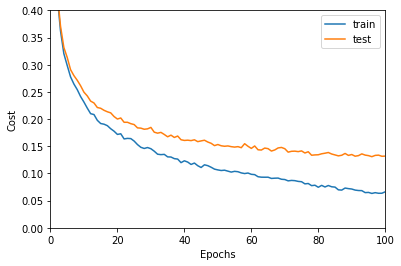

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(nepochs+1), epoch_cost_train, label="train")
plt.plot(range(nepochs+1), epoch_cost_test, label="test")
plt.ylabel('Cost')
plt.xlabel('Epochs')
xmax = nepochs
plt.axis([0,xmax,0.0,0.4])
plt.legend()
plt.show()

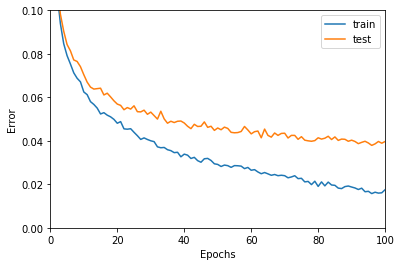

0.015733333333333332
0.0379


In [21]:
plt.plot(range(nepochs+1), epoch_error_train, label="train")
plt.plot(range(nepochs+1), epoch_error_test, label="test")
plt.ylabel('Error')
plt.xlabel('Epochs')
xmax = nepochs
plt.axis([0,xmax,0.0,0.1])
plt.legend()
plt.show()
print(np.min(epoch_error_train))
print(np.min(epoch_error_test))